## Setup

In [0]:
PROJ       = "fastmri"

In [2]:
# Mount Google Drive
from google.colab import drive # import drive from google colab
from pathlib import Path 

ROOT = "/content/drive"     # default location for the drive
drive.mount(ROOT)           # mount google drive at /content/drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
ALL_PROJ_PATH = Path(ROOT)/"My Drive/fastai_proj/"  # path to all projects 
PROJ_PATH   = ALL_PROJ_PATH/PROJ                    # path to project on PROJ
PROJ_PATH.mkdir(parents=True, exist_ok=True)        # make dir in PROJ to house Github

In [4]:
%run "$PROJ_PATH/common_constants_env.ipynb" # pip install fastai, fastmri, etc

pip install fastai2
git clone fastMRI
pip install ISMRMRD
pip install fasMRI req
sys append /content/fastMRI
imports


In [0]:
%run "$PROJ_PATH/03_kspace_tfms.ipynb" # get the tfms to test

## Data

### MRI data

In [0]:
import json

In [0]:
ds_name = "knee_singlecoil_val" # dataset name
DS2DIR = {"knee_singlecoil_val": "singlecoil_val"}

In [9]:
path_json = PROJ_PATH/"data"/DS2DIR[ds_name]/"fn2attr.json"
path_json

Path('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/fn2attr.json')

In [10]:
%time fn2attr = json.load(path_json)

CPU times: user 975 µs, sys: 134 µs, total: 1.11 ms
Wall time: 767 ms


In [0]:
fn2attr_items = L(i for i in fn2attr.items())

In [12]:
fn2attr_items

(#40) [('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000631.h5', {'n_slices': 40, 'kspace_shape': [40, 640, 372], 'padding_left': 19, 'padding_right': 354}),('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000314.h5', {'n_slices': 32, 'kspace_shape': [32, 640, 372], 'padding_left': 19, 'padding_right': 354}),('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000031.h5', {'n_slices': 40, 'kspace_shape': [40, 640, 372], 'padding_left': 19, 'padding_right': 354}),('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000480.h5', {'n_slices': 33, 'kspace_shape': [33, 640, 372], 'padding_left': 19, 'padding_right': 354}),('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000071.h5', {'n_slices': 35, 'kspace_shape': [35, 640, 372], 'padding_left': 19, 'padding_right': 354}),('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000537.h5', {'n_slices': 35, 'kspace_shape': [3

### Imagenette data

In [13]:
path_net = untar_data(URLs.IMAGENETTE_160)
fnames_net = get_image_files(path_net)

In [14]:
path_mnist = untar_data(URLs.MNIST)
fnames_mnist = get_image_files(path_mnist)

In [15]:
fn_test = fnames_net[0]
fn_test

Path('/root/.fastai/data/imagenette2-160/val/n03394916/n03394916_60810.JPEG')

## Real images

In [0]:
img = PILImageBW.create(fn_test)

In [82]:
# Pytorch tensor computation
onesided = True  # return half of array
print(f"Onesided = {onesided}")

t_arr = apply(img, RealTensorTfms.im2arr) # float tensor
orig_shape = t_arr.shape
print(f"Im tensor: shape {orig_shape}")

# using rfft
t_k             = apply(t_arr, RealTensorTfms.real2k(onesided=onesided))
t_rev_img       = apply(t_k, RealTensorTfms.k2real(onesided=onesided, s=orig_shape))
print(f"K Space: shape {t_k.shape}")
print(f"Rev Im: shape {t_rev_img.shape}")

# using fft - requires complex arr
fft_arr         = apply(t_arr, TensorTfms.real2complex)
print(f"Im complex tensor: shape {fft_arr.shape}")

t_fft_k         = apply(fft_arr, TensorTfms.real2k())
print(f"K Space: shape {fft_arr.shape}")

t_fft_rev_img   = apply(t_fft_k, TensorTfms.k2real())
print(f"Rev Im: shape {t_fft_rev_img.shape}")

# Viz kspace
t_k_log_abs     = apply(t_k, RealTensorTfms.log_magn)

Onesided = True
Im tensor: shape torch.Size([160, 161])
K Space: shape torch.Size([160, 81, 2])
Rev Im: shape torch.Size([160, 161])
Im complex tensor: shape torch.Size([160, 161, 2])
K Space: shape torch.Size([160, 161, 2])
Rev Im: shape torch.Size([160, 161])


In [0]:
np.testing.assert_array_almost_equal(t_arr, t_rev_img)
np.testing.assert_array_almost_equal(t_arr, t_fft_rev_img)

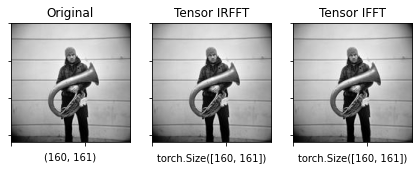

In [77]:
plot([img, t_rev_img, t_fft_rev_img], ["Original", "Tensor IRFFT", "Tensor IFFT"])

# Test batch

In [92]:
imgs = torch.stack(tuple([tensor(PILImageBW.create(fn)).double() for fn in fnames_mnist[0:10]]), dim=0)
imgs.shape

torch.Size([10, 28, 28])

In [96]:
# Pytorch tensor computation
onesided = True  # return half of array
print(f"Onesided = {onesided}")

t_arr = apply(imgs, RealTensorTfms.im2arr) # float tensor
orig_shape = t_arr.shape[-2], t_arr.shape[-1]
print(f"Im tensor: shape {orig_shape}")

# using rfft
t_k             = apply(t_arr, BatchRealTensorTfms.real2k(onesided=onesided))
print(f"K Space: shape {t_k.shape}")

t_rev_img       = apply(t_k, BatchRealTensorTfms.k2real(onesided=onesided, s=orig_shape))
print(f"Rev Im: shape {t_rev_img.shape}")

# using fft - requires complex arr
fft_arr         = apply(t_arr, BatchTensorTfms.real2complex)
print(f"Im complex tensor: shape {fft_arr.shape}")

t_fft_k         = apply(fft_arr, BatchTensorTfms.real2k())
print(f"K Space: shape {fft_arr.shape}")

t_fft_rev_img   = apply(t_fft_k, BatchTensorTfms.k2real())
print(f"Rev Im: shape {t_fft_rev_img.shape}")

# Viz kspace
t_k_log_abs     = apply(t_k, RealTensorTfms.log_magn)

Onesided = True
Im tensor: shape (28, 28)
K Space: shape torch.Size([10, 28, 15, 2])
Rev Im: shape torch.Size([10, 28, 28])
Im complex tensor: shape torch.Size([10, 28, 28, 2])
K Space: shape torch.Size([10, 28, 28, 2])
Rev Im: shape torch.Size([10, 28, 28])


In [0]:
np.testing.assert_array_almost_equal(t_arr, t_rev_img)
np.testing.assert_array_almost_equal(t_arr, t_fft_rev_img)

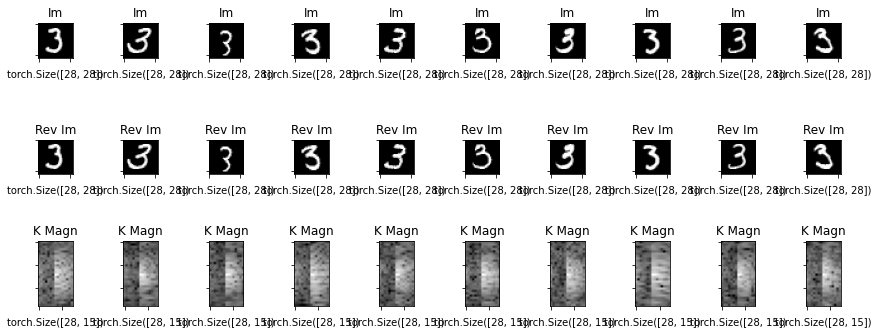

In [106]:
def tensor2list(x, n=10): return [x[i] for i in range(n)]

ims    = tensor2list(imgs) + tensor2list(t_rev_img) + tensor2list(t_k_log_abs)
titles = L("Im")*10 + L("Rev Im")*10 + L("K Magn")*10

plot(ims, titles, nrows=3, ncols=10, figsize=(12,5))

## MR images

In [0]:
# given fn2attr dict, indexes into array of kspace slices
class KSliceTfm(Transform):
  def __init__(self, fn2attr_items, is_valid=False):
    self.fn2attr_items, self.is_valid = fn2attr_items, is_valid
    self.n_slices = [attr["n_slices"] for (_, attr) in self.fn2attr_items]
    self.cumsum = np.cumsum(self.n_slices)
    self.total_n_slices = self.cumsum[-1]

  def encodes(self, i):
    fn2attr_idx  = np.searchsorted(self.cumsum, i)
    slice_idx = i - self.cumsum[fn2attr_idx]

    fname = self.fn2attr_items[fn2attr_idx][0]

    with h5py.File(fname, 'r') as data:
      kslice = data['kspace'][slice_idx]

    return kslice


In [0]:
kslices = KSliceTfm(fn2attr_items)

In [109]:
total_n_slices = kslices.total_n_slices
total_n_slices

1356

580
(640, 372) <class 'numpy.ndarray'>


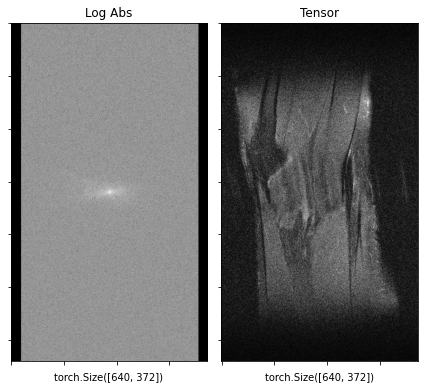

In [123]:
i = np.random.randint(0,total_n_slices)
print(i)

ck = kslices(i)
print(ck.shape, type(ck))

complex_img  = apply(ck, TensorTfmsBase.k2complex)
t_img          = apply(complex_img, T.complex_abs)

k_log_abs = apply(ck, TensorTfmsBase.log_magn, pre=T.to_tensor)

plot([k_log_abs, t_img], ["Log Abs", "Tensor"], ["gray_r", "gray"])